In [1]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

from torchvision import models
from torchvision import transforms
from torchvision.io import read_image

import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

from tqdm import tqdm

import random
import os

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
class CustomImageDataset(Dataset):
    def __init__(self, df, transform=None):

        self.df = df
        
        self.device = device
        
        self.transform = transform

    def __len__(self):
        return len(self.df)


    def __getitem__(self, idx):
        if idx >= len(self): raise StopIteration

        img = read_image(self.df.loc[idx, 'img_path'])[:3,:,:]
        filename = self.df.loc[idx, 'filename']
        sign = self.df.loc[idx, 'sign']
        
        if self.transform:
            img = self.transform(img)

        return img, filename, sign
    
    def getData(self):
        return list(self)

In [6]:
def createDataFrame():
    
    train_df = pd.read_csv('../data/train.csv')
    train_df['img_path'] = '../data/avia-train/avia-train/' + train_df['filename'] + '.png'
    
    test_df = pd.read_csv('../data/test.csv')
    test_df['img_path'] = '../data/avia-test/avia-test/' + test_df['filename'] + '.png'
    test_df['sign'] = -1
    
    test_e_df = pd.read_csv('../data/test_extended.csv', index_col='filename')
    
    test_e_df = test_e_df.drop(test_df['filename'])
    test_e_df['filename'] = test_e_df.index
    
    test_e_df['img_path'] = '../data/avia-test-extended/avia-test-extended/' + test_e_df['filename'] + '.jpeg'
    test_e_df['sign'] = -1
    
    df = pd.concat((train_df, test_df, test_e_df)).reset_index(drop=True)
    
    df['sign'] = df['sign'].astype('float64')
    
    return df

In [7]:
def createDataLoader(df, batch_size=None, shuffle=False, transform=None):

    batch_size = batch_size if batch_size else len(df)
    
    dataset = CustomImageDataset(df, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    
    return dataset, dataloader

In [8]:
df = createDataFrame()

In [9]:
model = models.resnet152(pretrained=True)

for param in list(model.parameters())[:-4]:
    param.require = False
    
model.fc = torch.nn.Sequential(
    nn.Linear(model.fc.in_features, 1),
    nn.Sigmoid()
)

weight = torch.tensor([sum(df['sign'] == 1) / sum(df['sign'] != -1)])
criterion = nn.BCELoss(weight=weight, reduction='mean')
criterion.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [10]:
%%time

def f():
    log = {'loss': {'train': [], 'val': []}, 'bestModel': None}
    
    epochs = 35
    
    train_df, val_df = train_test_split(df[df['sign'] != -1], test_size=0.2, random_state=42)
    train_df, val_df = train_df.reset_index(drop=True), val_df.reset_index(drop=True)
    
    traintransform = transforms.Compose([
        transforms.ToPILImage(),

        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),

        transforms.ToTensor(),
    ])
    _, train_dataloader = createDataLoader(train_df, batch_size=500, shuffle=True, transform=traintransform)
    
    valTransform = transforms.Compose([
        transforms.ToPILImage(),

        transforms.ToTensor(),
    ])
    _, val_dataloader = createDataLoader(val_df, batch_size=500, shuffle=True, transform=valTransform)
    
    
    model.to(device)
    
    for epoch in range(epochs):
        # Train
        model.train()
        running_loss = 0
        for X, _, y in train_dataloader:
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device).float().reshape(-1, 1)
            
            y_predict = model(X)

            loss = criterion(y_predict, y)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
        log['loss']['train'].append(running_loss/len(train_dataloader))
        
        # Val
        model.eval()
        running_loss = 0
        for X, _, y in val_dataloader:
            
            X, y = X.to(device), y.to(device).float().reshape(-1, 1)
            y_predict = model(X)
            
            
            loss = criterion(y_predict, y)
            running_loss += loss.item()
            
    
        log['loss']['val'].append(running_loss/len(val_dataloader))
        
        if not log['bestModel'] or log['loss']['val'][-1] < min(log['loss']['val'][:-1]):
            log['bestModel'] = model
            log['bestEpoch'] = epoch + 1
        
        print(f"Epoch: {epoch+1} / {epochs} | Train loss: {log['loss']['train'][-1]} | Val loss: {log['loss']['val'][-1]}")
            
    return log
        
log = f()    

Epoch: 1 / 35 | Train loss: 0.04599035037681461 | Val loss: 0.028879269670981627
Epoch: 2 / 35 | Train loss: 0.014120766492560506 | Val loss: 0.012856248264702467
Epoch: 3 / 35 | Train loss: 0.009588440712541342 | Val loss: 0.012660456749682244
Epoch: 4 / 35 | Train loss: 0.008506636405363678 | Val loss: 0.013783022188223325
Epoch: 5 / 35 | Train loss: 0.007300806911662221 | Val loss: 0.010633512185170101
Epoch: 6 / 35 | Train loss: 0.005321165714412927 | Val loss: 0.010311687580094887
Epoch: 7 / 35 | Train loss: 0.00474159297067672 | Val loss: 0.010602861929398317
Epoch: 8 / 35 | Train loss: 0.003830888085067272 | Val loss: 0.010706721160274286
Epoch: 9 / 35 | Train loss: 0.0033325108911958523 | Val loss: 0.014567479813614717
Epoch: 10 / 35 | Train loss: 0.003579497962491587 | Val loss: 0.009358862414956093
Epoch: 11 / 35 | Train loss: 0.0027439636248163877 | Val loss: 0.011595016381201835
Epoch: 12 / 35 | Train loss: 0.0029214680148288608 | Val loss: 0.009765218782167021
Epoch: 13 / 

22


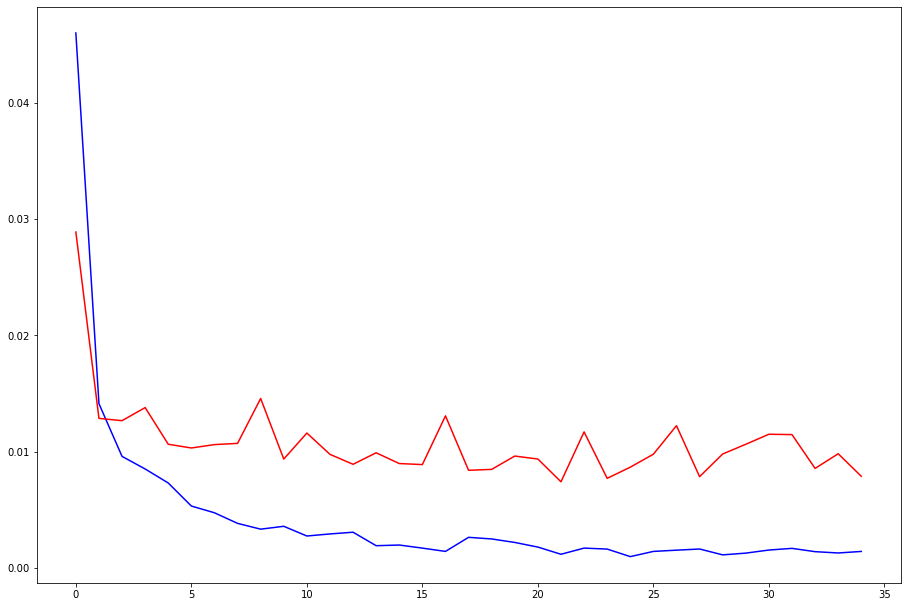

In [11]:
print(log['bestEpoch'])

fig = plt.figure()
axes = fig.add_axes([1, 1, 2, 2])

axes.plot(range(len(log['loss']['train'])), log['loss']['train'], 'b')
axes.plot(range(len(log['loss']['val'])), log['loss']['val'], 'r')
plt.show()

In [12]:
model = log['bestModel']

In [13]:
%%time
with torch.no_grad():
    model.eval()
    model.to(device)

    test_df = df[df['sign'] == -1]
    test_df = test_df.reset_index(drop=True)
    
    testTransform = transforms.Compose([
        transforms.ToPILImage(),

        transforms.ToTensor(),
    ])
    _, test_dataloader = createDataLoader(test_df, batch_size=500, shuffle=True, transform=testTransform)
    
    filenames = []
    predicteds = []
    
    for X, filename, _ in test_dataloader:
        X = X.to(device)
        y_predicted = model(X)
        y_predicted = y_predicted.reshape(-1).cpu()
        
        filenames += filename
        predicteds.append(y_predicted)
        
predicteds = torch.cat(predicteds, 0)

Wall time: 1min 54s


In [14]:
predict_df = pd.DataFrame({
    'sign': predicteds,
    'filename': filenames
})

In [15]:
predict_df

sign                              filename
0       8.352637e-08  405e2062-8a95-4a70-8b3c-a4e841e79ee3
1       5.408464e-07  e9df33fe-3315-46e5-89ac-4067905abba6
2       9.998835e-07  3b4be37d-7001-42b0-890d-b8dbee375e9a
3       1.560951e-07  debb94fa-ae05-4890-a82f-34d08e8ba306
4       5.853166e-07  bcdd1ec9-a18f-487d-b83f-b6fed5034060
...              ...                                   ...
100995  2.378746e-06  500a0420-b3b2-4b5f-936f-40ca003a1ef5
100996  1.112003e-07  51a166cb-6b3d-419f-b906-503ba3f20e98
100997  1.088951e-07  d8fe3efb-8241-4fb8-9ecb-80df431b1267
100998  3.925533e-07  9034905b-e807-4753-b3e9-3918a9c66c86
100999  2.004618e-08  8bfd94f0-bab9-40d0-a5f5-13f2447971e5

[101000 rows x 2 columns]

In [16]:
predict_df.to_csv('../predict/6.csv', index=False)